# Attention is all you need

In pytorch ❤️❤️

Source material:
http://nlp.seas.harvard.edu/2018/04/03/attention.html

In [1]:
# !pip install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="talk")
sns.set()
%matplotlib inline

In [3]:
print(torch.__version__)
print(np.__version__)

0.4.0
1.14.2


# Model Architecture
![Model architecture](images/the-annotated-transformer_14_0.png)

Most competitive neural sequence transduction models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations $(x1,…,xn)$ to a sequence of continuous representations $z=(z1,…,zn)$. Given $z$, the decoder then generates an output sequence $(y1,…,ym)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

In [4]:
class EncoderDecoder(nn.Module):
    """
    Standard Encoder-Decoder architecture.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator # Unused??
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        """Takes in masked source and target sequences. 
        At each run of forward, outputs one sequence of softmax probabilities
        """
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [5]:
class Generator(nn.Module):
    "Single linear layer + softmax. To be used for outputing words (not trained?) TODO: CLARIFY"
    def __init__(self, d_model, d_vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, d_vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder Decoder Stacks

### Encoder

The encoder comprises of $N = 6$ layers.

In [6]:
def clones(module: nn.Module, N: int) -> nn.ModuleList:
    """Convenience function for producing N identical layers
    
    Args:
        module (nn.Module): Instantiated nn.Module layer
        N (int): Number of copies
        
    Returns:
        nn.ModuleList of modules
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [7]:
# test = clones(nn.Linear(10, 6), 2)
# hex(id(test[0])), hex(id(test[1]))

For each of the two sublayers, we use a residual connection, followed by layer norm.

That is, the output of each sub-layer is $ LayerNorm( x + Sublayer(x)) $, where $Sublayer(x)$ is the function implemented by the sublayer itself.

To facilitate residual connections, all sub-layers, as well as embedding layers, produce dimension $d_{model} = 512$

In [8]:
class SublayerConnection(nn.Module):
    """Residual connection followed by layernorm (and dropout).
    
    Note the order of norm is first rather than last. This is for simplicity 
    (as we will be wrapping another norm layer at the output of the entire Encoder/Decoder). (TODO: CLARIFY)
    """
    def __init__(self, size: int, dropout: float):
        super(SublayerConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [9]:
class Encoder(nn.Module):
    def __init__(self, layer: nn.Module, N: int):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

The core of the encoder is made up of two-sublayers. The first is multi-head self-attention, second is position-wise fully connected feed-foward network.

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 size: int, 
                 self_attn: nn.Module,
                 feed_forward: nn.Module, 
                 dropout: float):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayers = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayers[1](x, self.feed_forward)

### Decoder
The decoder is also a stack of $ N = 6$ identical layers.

In [11]:
class Decoder(nn.Module):
    def __init__(self, layer: nn.Module, N: int):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [12]:
class DecoderLayer(nn.Module):
    """Self-attn -> src-attn -> Pos-FFN"""
    def __init__(self, 
                 size: int, 
                 self_attn: nn.Module,
                 src_attn: nn.Module,
                 feed_forward: nn.Module, 
                 dropout: float):
        super(DecoderLayer, self).__init__()
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayers = clones(SublayerConnection(size, dropout), 3)
        self.size = size
        
    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayers[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
        return self.sublayers[2](x, self.feed_forward)
    

## Attention

$$ Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}}) V $$

In [13]:
def attention(query: torch.Tensor, 
              key: torch.Tensor, 
              value: torch.Tensor, 
              mask: torch.Tensor=None, 
              dropout: nn.Module=None):
    """Scaled dot product attention
    query: (batch_size, num_queries (max_tgt_len), q_dim)
    key: (batch_size, num_keys (max_src_len), k_dim)
    dropout [nn.Module]:  Dropout layer
    mask: broadcastable tensor (along q * k.T). 0's will be fill with -Inf
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # (batch_size, num_query, num_keys)
    
    #Apply mask
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    #For each query, apply softmax across keys
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
        
    return torch.matmul(p_attn, value), p_attn    

### Multi headed attention

![Multi-headed Attention](images/multi_head.png)

In [14]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, num_head: int, d_model: int, dropout: int=0.1):
        """Takes num_head and model_size"""
        super(MultiHeadedAttention, self).__init__()
        assert(d_model % num_head == 0)
        # Assume d_v == d_k
        self.d_k = d_model // num_head
        self.h = num_head
        self.linears = clones(nn.Linear(d_model, d_model), 4) #K, V, Q, and output
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # This step is to 
            mask = mask.unsqueeze(1)
        
        batch_size = query.size(0)
        
        # (1) Linear projections (in batch) from d_model -> d_k ( x num_heads)
        Q, K, V = [layer(x) for layer, x in zip(self.linears, (query, key, value))]
        
        # (2) Simulate 'multi-head' by changing view (turn self.h into dim 1)
        Q, K, V = [x.view(batch_size, -1, self.h, self.d_k).transpose(1, 2) for x in (Q, K, V)]
        
        # (2) Vectorised attention (performed on last two dimension)
        x, self.attn = attention(Q, K, V, mask=mask, dropout=self.dropout)
        
        # (3) Simulated concat with a view
        #Note: transpose causes Tensor to become non-contiguous (which view requires)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)
        
        return self.linears[-1](x)

## Masking

> The target mask is a convenience mechanism to prevent the self-attention sub-layer in the decoder stack from looking at 'future words'. The encoder stack should have all ones for the mask. The mask itself is a square matrix, of which target word (row) is allowed to read (column).

In [15]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

## Position-wise Feed-forward networks

In [16]:
# Similar to 1D-convolution. Pytorch's Linear works on (N, *, in_dim) approach
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [17]:
# d_model = 12
# d_ff = 16
# w_1 = nn.Linear(d_model, d_ff)
# w_2 = nn.Linear(d_ff, d_model)

# x = torch.ones(8, 100, d_model)
# w_1(x).size()

## Embeddings

In [18]:
class Embeddings(nn.Module):
    def __init__(self, d_model: int, vocab: int):
        super(Embeddings, self).__init__()
        self.embed = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model)

## Positional encoding

$ PE_{(pos, 2i)} = sin(pos / 10000^{2i/d_{model}})$

$ PE_{(pos, 2i+1)} = cos(pos / 10000^{2i/d_{model}})$

where $pos$ is the position, and $i$ is the feature dimension index

In the feature dimension, the odd features are phase shifted ($+90^\circ$)

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Generate PE matrix; during forward op we truncate according to length of input
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len)
        div_term = torch.pow(10000.0, -torch.arange(0, d_model, 2) / d_model)
        
        #Even 
        pe[:, 0::2] = torch.sin(torch.ger(position, div_term)) #torch.ger => outer pdt
        pe[:, 1::2] = torch.cos(torch.ger(position, div_term))
        
        pe = pe.unsqueeze(0)
        #This causes the parameter to be in the state dict?
        # Needs more clarity
        #https://discuss.pytorch.org/t/use-and-abuse-of-register-buffer/4128
        #https://discuss.pytorch.org/t/why-do-we-need-to-register-parameters-in-pytorch-when-using-nn-modules/5996/2
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)
        
        

In [20]:
# Positional encoding
d_model = 16
max_len = 24

pe = torch.zeros(max_len, d_model)
position = torch.arange(0, max_len).unsqueeze(1)
#div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
div_term2 = torch.pow(10000.0, -torch.arange(0, d_model, 2) / d_model) #Clearer?

In [21]:
position = torch.arange(0, max_len)
div_term2 = torch.pow(10000.0, -torch.arange(0, d_model, 2) / d_model)

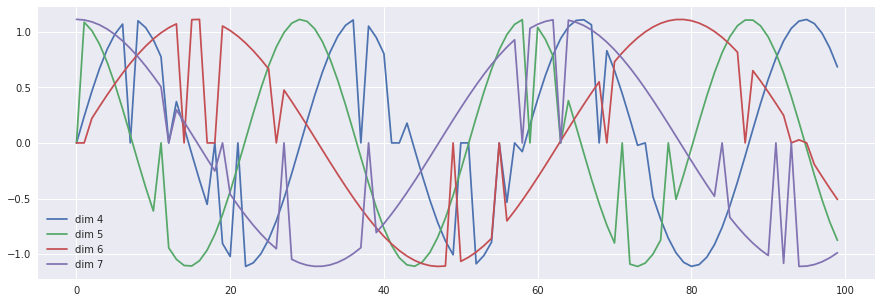

In [22]:
pe = PositionalEncoding(24, 0.1)
y = pe(torch.zeros(1, 100, 24))
plt.figure(figsize=(15,5))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()

## Full Model
Full model construction goes below

In [23]:
def make_model(src_vocab: int, tgt_vocab: int, N: int=6, 
               d_model: int=512, d_ff: int=2048, h: int=8, dropout :float=0.1):
    """Construct transform model"""
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    pos_enc = PositionalEncoding(d_model, dropout)
    
    model = EncoderDecoder(Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
                          Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
                          nn.Sequential(Embeddings(d_model, src_vocab), c(pos_enc)),
                          nn.Sequential(Embeddings(d_model, tgt_vocab), c(pos_enc)),
                          Generator(d_model, tgt_vocab))
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [24]:
test_model = make_model(10, 10, 2)

In [25]:
model_size = sum(p.view(-1).size(0) for p in test_model.parameters())
print(model_size)

14730250


# Training

In [26]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum().item()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

## Training loop


In [27]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [28]:
# Loss


# Optimizer
We used the Adam optimizer with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{−9}$. We varied the learning rate over the course of training, according to the formula:

$$ lr = d^{-0.5}_{model}\cdot min(step^{-0.5}, step \cdot warmup^{-1.5})$$

i.e. Linear increase in learning rate for first $warmup$ steps, then decreasing proportionately to sqrt of step number subsequently. We use $warmup = 4000$

In [29]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

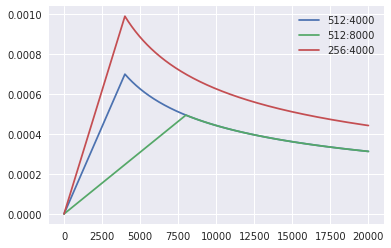

In [30]:
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
plt.show()

## Regularization

### Label smoothing

In [31]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        """Takes in a 2-D vector x
        Args:
        x (torch.Tensor): batch_size * self.size
        target (torch.Tensor): batch_size 
        """
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        #print('target:', target.data, self.padding_idx)
        #print('mask:', mask.size(), mask, mask.dim(), len(mask))
        #print('size:', mask.squeeze().size())
        # Check if any of the labels are padding
        if len(mask) > 0: #mask.dim() > 0: # Not
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist)

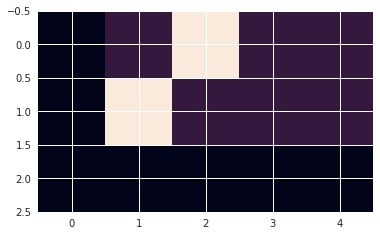

In [32]:
crit = LabelSmoothing(5, 0, 0.3)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
plt.show()

# Toy task

Simple copy task.

In [33]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [34]:
for batch in data_gen(10, 4, 1):
    print(batch)

In [35]:
print(batch.src[0, :])
print(batch.trg_y[0, :])
print(batch.trg_mask[0, :, :])
print(batch.src_mask[0, :, :])

tensor([ 1,  6,  5,  6,  3,  5,  6,  9,  5,  1])
tensor([ 6,  5,  6,  3,  5,  6,  9,  5,  1])
tensor([[ 1,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1]], dtype=torch.uint8)
tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1]], dtype=torch.uint8)


## Loss computation

In [36]:
# Not necessary to have a class -> Turn into functional?
class SimpleLossCompute:
    "Wrapper for computing loss and performing training"
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm
        #return loss.data[0] * norm

In [37]:
if False:
    # Train the simple copy task.
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=2)
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

    for epoch in range(10):
        model.train()
        run_epoch(data_gen(V, 30, 20), model, 
                  SimpleLossCompute(model.generator, criterion, model_opt))
        model.eval()
        print(run_epoch(data_gen(V, 30, 5), model, 
                        SimpleLossCompute(model.generator, criterion, None)))

In [38]:
# Greedy decoding
def greedy_decoding(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    out_symbols = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    #Decode one step at a time
    for i in range(max_len - 1):
        out = model.decode(memory, src_mask,
                          out_symbols,
                          subsequent_mask(out_symbols.size(1)).type_as(src.data))
        prob = model.generator(out[:, -1])
        # Extract max probable word
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        out_symbols = torch.cat([out_symbols,
                       torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=1)
        
    return out_symbols

In [39]:
if False:
    model.eval()
    for _ in range(2):
        src = torch.from_numpy(np.random.randint(1, 10, size=(1, 10)))
        src[:, 0] = 1
        #src = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]])
        src_mask = torch.ones(1, 1, 10)
        print("Source sequence:", src)
        print("Output sequence:", greedy_decoding(model, src, src_mask, max_len=10, start_symbol=1))

# Real world translation task

IWSLT DE-EN task (smaller than WMT)

In [40]:
# !pip install torchtext spacy
# !python -m spacy download en
# !python -m spacy download de

## Data loading


In [41]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

In [42]:
#TODO: CLARIFY
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

Iterator to patch over torch.text's default iterator?

In [43]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

In [44]:
# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, 
                                                devices=self.devices)
        out_scatter = nn.parallel.scatter(out, 
                                          target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i+chunk_size].data, 
                                    requires_grad=self.opt is not None)] 
                           for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data.item()

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

In [45]:
# TODO: Patch for 0.4.0
USE_CUDA = True
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using : %s" % device)
#devices = [0] #, 1, 2, 3
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.to(device)
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.to(device)
    BATCH_SIZE = 4000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    #model_par = nn.DataParallel(model, device_ids=devices)

Using : cuda


In [49]:
if True:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        #model_par.train()
        model.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model,
                  SimpleLossCompute(model.generator, criterion, opt=model_opt))
                  #MultiGPULossCompute(model.generator, criterion, 
                  #                    devices=devices, opt=model_opt))
        #model.eval()
        
        #model_par.eval()
        with torch.no_grad():
            loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                              model, 
                              SimpleLossCompute(model.generator, criterion, opt=model_opt))
                              #MultiGPULossCompute(model.generator, criterion, 
                              #devices=devices, opt=None))
            print(loss)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCStorage.cu:58